In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gradient_input import GradientInput
from model_dev import rmse
import prediction_painter
from datetime import datetime as dt
import os
import import_ipynb
from Model_dev import get_model

importing Jupyter notebook from Model_dev.ipynb
importing Jupyter notebook from model_dev.ipynb


In [2]:
def diff_cases(df, columns, methods=0):
    tmp = df.copy()
    if methods == 0:
        for column in columns:
            if column in numerical:
                tmp[column] =df[column].rolling(14).mean().shift(14) - df[column].rolling(14).mean()
            else:
                tmp[column] = df[column].shift(7) - df[column]
        #df[target] = df[target].rolling(14).mean().shift(14) - df[target].rolling(14).mean()
    return tmp

In [3]:
def find_date(cases_df, first_date, last_date):
    Date = {}
    for date in cases_df.index:
        if dt.strptime(date, "%d/%m/%Y") > dt.strptime(first_date, "%d/%m/%Y") and dt.strptime(date, "%d/%m/%Y") < dt.strptime(last_date, "%d/%m/%Y"):
            
            ###### Make an assumption, where the case must be greater than 100
            if (cases_df.loc[:date, 'Daily_cases'].values[-4] - cases_df.loc[date:,'Daily_cases'].values[2]) > 0 and cases_df.loc[:date, 'Daily_cases'].values[-4] > 100:
                Date[date] = cases_df.loc[date:, 'Daily_cases'].values[2] / cases_df.loc[:date, 'Daily_cases'].values[-4]
    return Date

def getPolicies(Date, country, method=0):
    p_changes = pd.DataFrame(columns=['Date', 'Methods', *columns])
    
    for target_date, _ in Date.items():

        _result = []
        for interv in columns:
            conditions = [cases_df.loc[:target_date,:].tail(14)[interv].values.mean() > 0,
                          cases_df.loc[:target_date,:].tail(14)[interv].values.mean() == 0 ,
                          cases_df.loc[:target_date,:].tail(14)[interv].values.mean() < 0]
            changes = str(np.select(conditions, results, default='0'))
            _result.append(changes)

        p_changes = p_changes.append(pd.Series([target_date, method, *_result], index = p_changes.columns), ignore_index=True)
    
    p_changes.set_index('Date', inplace=True)
    p_changes.to_csv(os.path.join(recommend_dir, "{}_p_changes_{}.csv".format(country, method)))
    return p_changes

In [4]:
def getGradient(Date, country, method=0):
    
    log_file = os.path.join(logdir,"Models.csv")
    best_result = get_model(log_file, country)
    index = best_result.index.values[0]
    df_log = pd.read_csv(log_file, index_col=0)
    algo, model_path, f_flag, country = prediction_painter.plot_from_dataframe(df_log, index, custom_objects= dict(loss=rmse))
    TargetGradient = GradientInput(algo, model_path, f_flag, country)
    
    recommend_changes = pd.DataFrame(columns=['Date', 'Methods', *columns])
    for date, _ratio in Date.items():
        
        df_gradient = TargetGradient.gradient_input(date, ratio=_ratio, gradient_only =True)
        df_gradient.drop(set(df_gradient.index.tolist()).difference(set(columns)), inplace=True)
        gradients = df_gradient.mean(1)
        _result = []
        for interv in gradients.index:
            conditions = [gradients[interv] > 0.05, -0.05 <= gradients[interv] <= 0.05, gradients[interv] < -0.05]
            gradient = str(np.select(conditions, results, default='0'))
            _result.append(gradient)

        recommend_changes = recommend_changes.append(pd.Series([date, method, *_result], index = recommend_changes.columns), ignore_index=True)
        
    recommend_changes.set_index('Date', inplace=True)
    recommend_changes.to_csv(os.path.join(recommend_dir, "{}_recommend_changes_{}.csv".format(country, method)))
    return recommend_changes

In [5]:
def accuracy(p_changes, recommend_changes, country):    
    count = correct = 0
    finalized_df = pd.DataFrame(columns=['Date', *columns])
    for i in range(len(p_changes.index)):
        changed = False
        changed_policies = {}
        changed_policies['Date'] = p_changes.index[i]
        for j in range(2, len(p_changes.columns)):
            if p_changes.iloc[i,j] != 'S':
                changed = True
                count += 1
                changed_policies[p_changes.columns[j]] = p_changes.iloc[i,j]
                if recommend_changes.iloc[i,j] == p_changes.iloc[i,j]:
                    correct += 1
                    changed_policies[p_changes.columns[j]] = p_changes.iloc[i,j] + " CORRECT"
        if changed:
            finalized_df = finalized_df.append(changed_policies, ignore_index=True)

    finalized_df.set_index('Date', inplace=True)
    finalized_df.to_csv(os.path.join(recommend_dir, "{}_finalized.csv".format(country)))
    return finalized_df, correct/count

In [6]:
columns = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport',
       'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H7_Vaccination policy',
       'H8_Protection of elderly people',
       'V1_Vaccine Prioritisation (summary)',
       'V2_Vaccine Availability (summary)',
       'V3_Vaccine Financial Support (summary)']

numerical = ['E3_Fiscal measures', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines']
target = ['Daily_cases']            
countries = ['United States', 'India', 'Brazil', 'Mexico']
results = ['U', 'S', 'L']
recommend_dir = os.path.join(os.getcwd(), "Recommendation")
logdir = os.path.join(os.getcwd(), "Log")

In [7]:
if not os.path.isdir(recommend_dir):
    os.mkdir(recommend_dir)

##### United States #####
##### Reshape and MinMaxScale input #####
(535, 14, 24) (535, 7, 1) (60, 14, 24) (60, 7, 1)


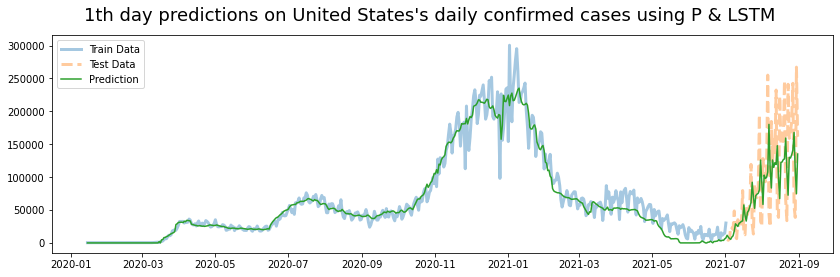

##### Reshape and MinMaxScale input #####
(535, 14, 24) (535, 7, 1) (60, 14, 24) (60, 7, 1)
LSTM Models\20211023 22-55LSTM P United States
X shape: (595, 14, 24)  y shape: (595, 7, 1)
Date Range:1/1/2020~31/8/2021


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


##### India #####
##### Reshape and MinMaxScale input #####
(536, 14, 26) (536, 7, 1) (60, 14, 26) (60, 7, 1)


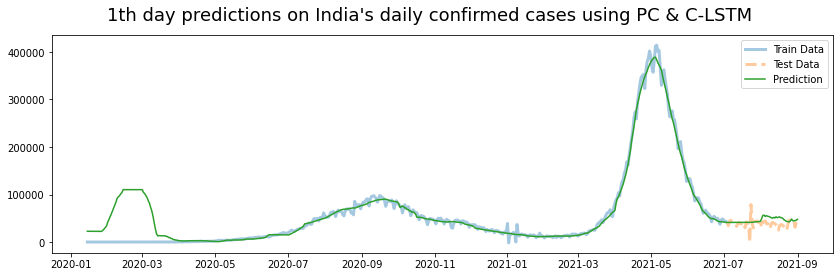

##### Reshape and MinMaxScale input #####
(536, 14, 26) (536, 7, 1) (60, 14, 26) (60, 7, 1)
C-LSTM Models\20211027 20-15C-LSTM PC India
X shape: (596, 14, 26)  y shape: (596, 7, 1)
Date Range:1/1/2020~1/9/2021


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


##### Brazil #####
##### Reshape and MinMaxScale input #####
(529, 14, 24) (529, 7, 1) (59, 14, 24) (59, 7, 1)


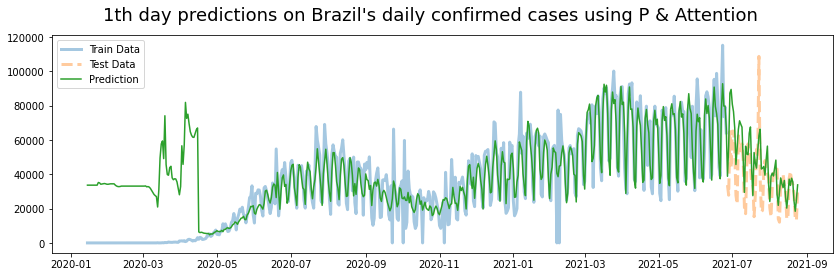

##### Reshape and MinMaxScale input #####
(529, 14, 24) (529, 7, 1) (59, 14, 24) (59, 7, 1)
Attention Models\20211027 03-56Attention P Brazil
X shape: (588, 14, 24)  y shape: (588, 7, 1)
Date Range:1/1/2020~24/8/2021


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


##### Mexico #####
##### Reshape and MinMaxScale input #####
(541, 14, 24) (541, 7, 1) (61, 14, 24) (61, 7, 1)


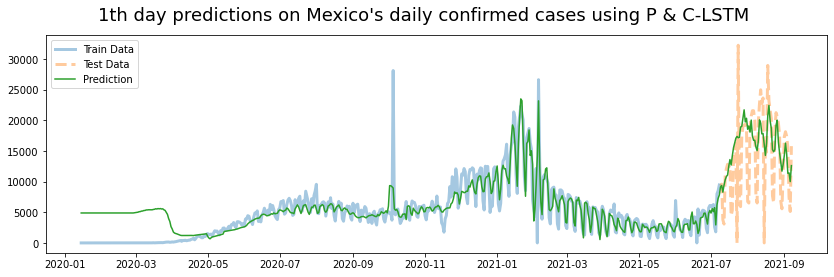

##### Reshape and MinMaxScale input #####
(541, 14, 24) (541, 7, 1) (61, 14, 24) (61, 7, 1)
C-LSTM Models\20211027 18-59C-LSTM P Mexico
X shape: (602, 14, 24)  y shape: (602, 7, 1)
Date Range:1/1/2020~7/9/2021


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]


{'United States': 0.11670480549199085, 'India': 0.03614457831325301, 'Brazil': 0.25133689839572193, 'Mexico': 0.20833333333333334}


In [8]:
system_results = {}

for i in range(len(countries)):
    
    country = countries[i]
    df = pd.read_csv("Data/Full_{}.csv".format(country), index_col = 0)
    df = df.set_index('Date')
    cases_df = diff_cases(df, columns+target)
    first_date = cases_df.index[160]
    last_date = cases_df.index[-22]
    
    print("#####", country, "#####")
    Date = find_date(cases_df, first_date, last_date)
    p_changes = getPolicies(Date, country)
    rec_changes = getGradient(Date, country)
    Finalized, acc = accuracy(p_changes, rec_changes, country)
    system_results[country] = acc

print(system_results)

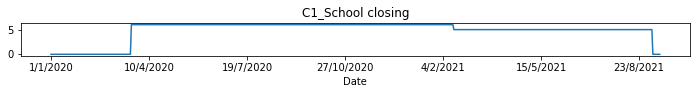

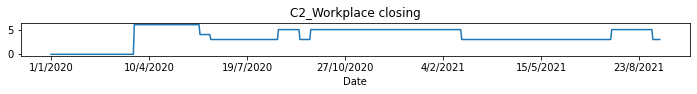

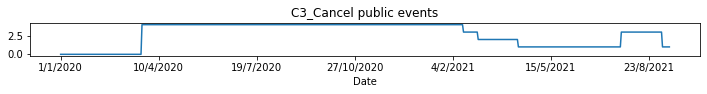

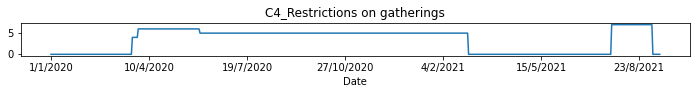

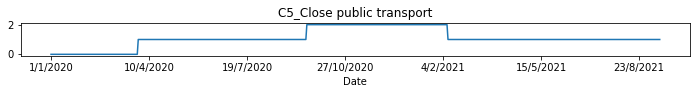

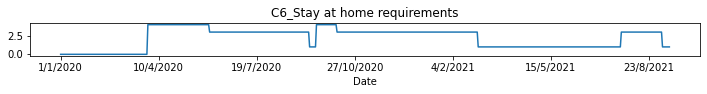

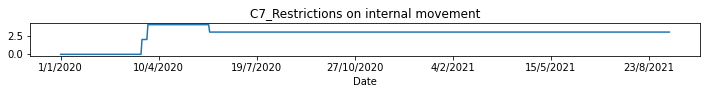

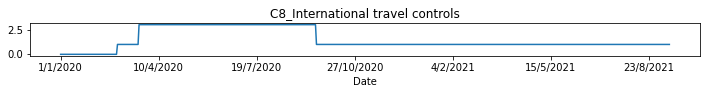

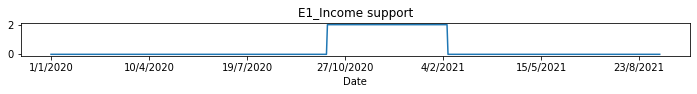

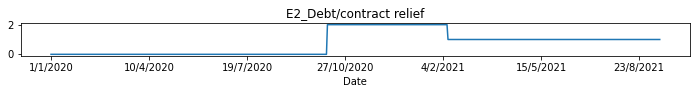

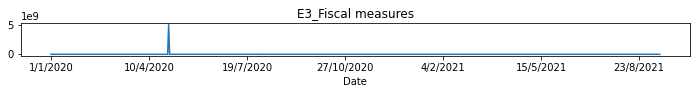

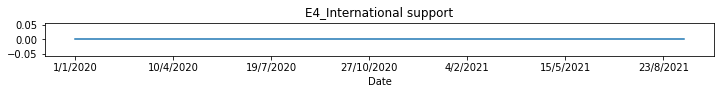

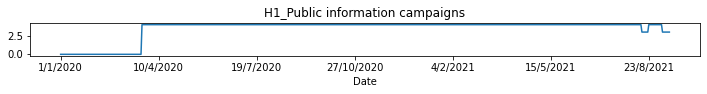

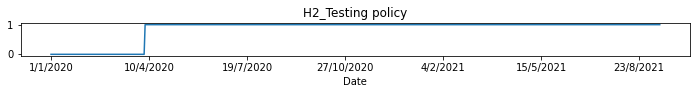

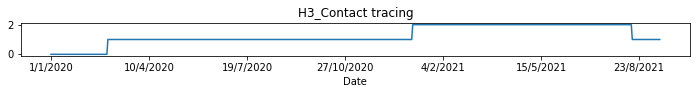

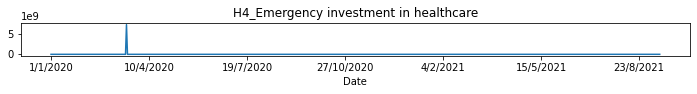

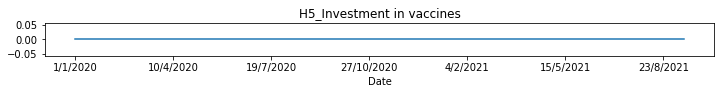

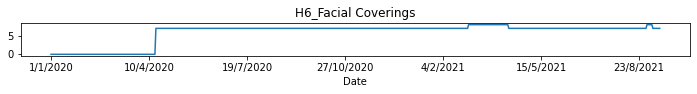

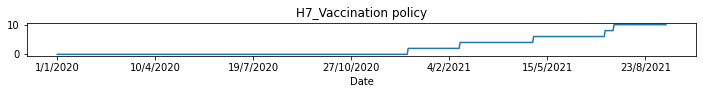

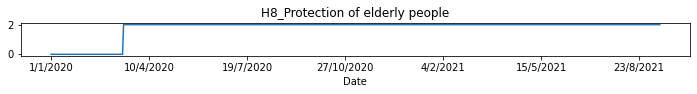

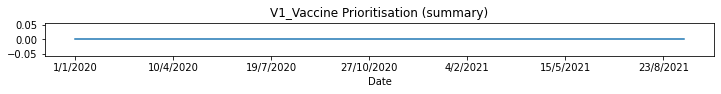

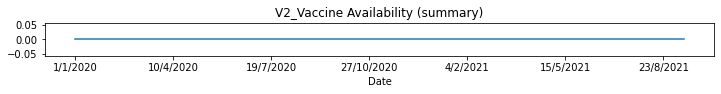

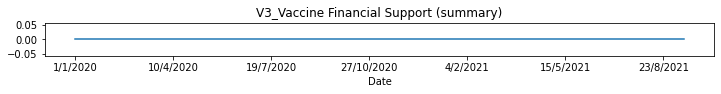

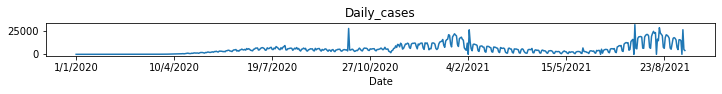

In [9]:
for column in columns+target:
    df[column].plot(figsize = (12,.6))
    plt.title(column)
    plt.show()

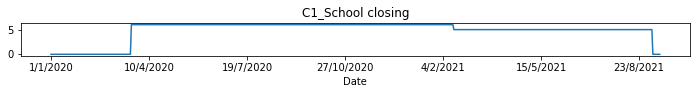

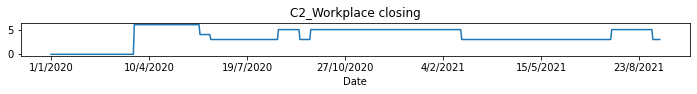

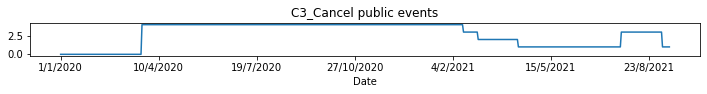

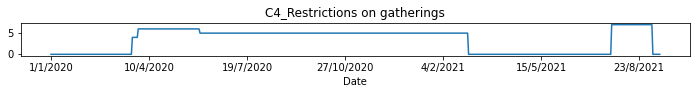

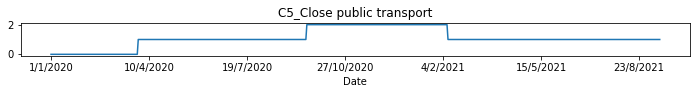

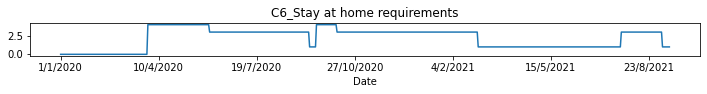

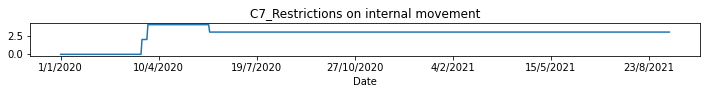

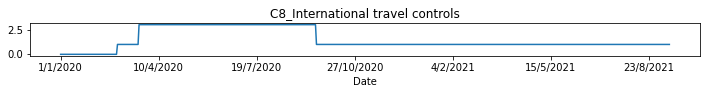

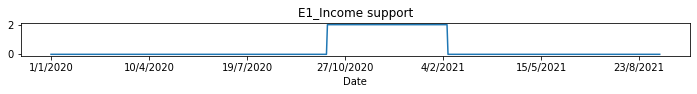

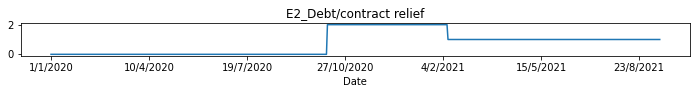

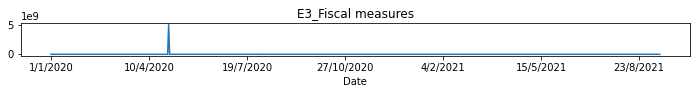

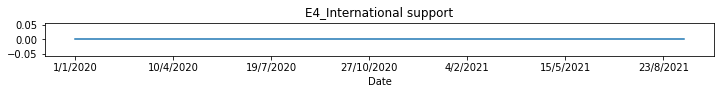

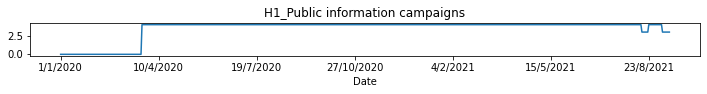

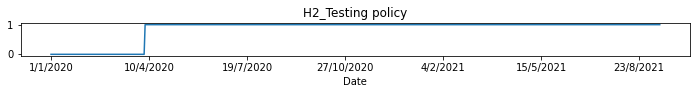

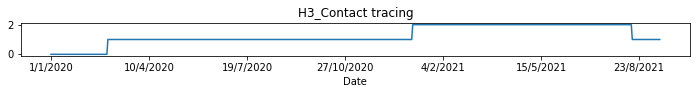

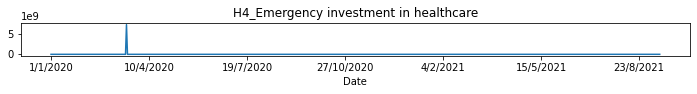

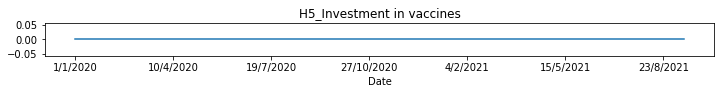

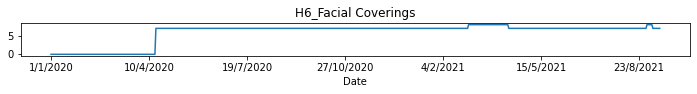

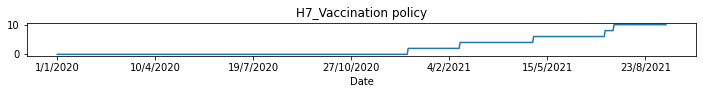

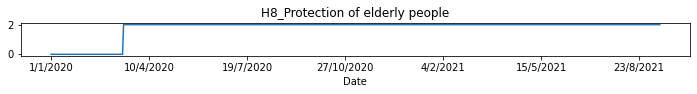

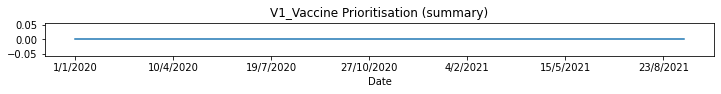

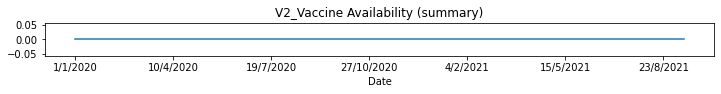

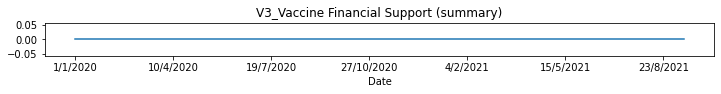

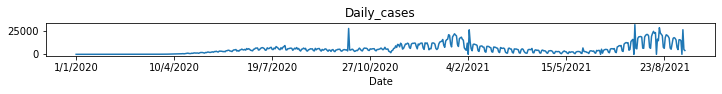

In [10]:
for column in columns+target:
    df[column].plot(figsize = (12,.6))
    plt.title(column)
    plt.show()